In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [2]:
# import dataset
iris = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
)

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [3]:
# Break the data into batches
## Use scikitlearn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)

## Convert data into pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

## Create data loder objects
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    shuffle=True,
    generator=torch.Generator(device),
)

In [4]:
# Function to create ANN model
def createNewModel(lr=0.005):

    # Model Architecture
    ANNIris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    )

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=lr)

    # Function return statement
    return ANNIris, lossFun, optimizer

In [5]:
# Explotre the model in more detail
tmpModel = createNewModel()[0]

# Print the model architecture
print(tmpModel)

# Print the model's parameter
for i in tmpModel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [ ]:
# Train the model
def trainTheModel(ANNIris, lossFun, optimizer, L1Lambda, L2Lambda, nEpochs=5000):

    # Initialize the accuracies and losses as empty array
    trainAcc = []
    testAcc = []
    losses = []

    # Count the total number of weights in the model
    nWeights = 0
    for pname, weight in ANNIris.named_parameters():
        if "bias" not in pname:
            nWeights = nWeights + weight.numel()

    # For loop over epochs
    for epoch in range(nEpochs):
        # Initialize batchAcc and batchLoss
        batchAcc = []
        batchLoss = []

        # Switch model into train mode
        # ANNIris.train() # Not required as dropout not implemented

        # Loop over batches
        for X, y in train_loader:

            # Forward pass
            yHat = ANNIris(X)
            loss = lossFun(yHat, y)

            # L1 regularization
            L1_term = torch.tensor(0.0, requires_grad=True)
            L2_term = torch.tensor(0.0, requires_grad=True)

            ## Sum up all abs(weights)
            for pname, weight in ANNIris.named_parameters():
                if "bias" not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
                    L2_term = L2_term + torch.sum(torch.abs(weight**2))

            # Add to loss term
            loss = (
                loss + (L1Lambda * L1_term / nWeights) + (L2Lambda * L2_term / nWeights)
            )

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compte batch training accuracy and loss
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            )
            batchLoss.append(loss.item())

        # Get average training accuracy for this epoch
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Test accuracy
        # ANNIris.eval()  # Model Evaluation mode # Not required as dropout not implemented
        X, y = next(iter(test_loader))  # X, y from test loader dataloader
        predlabels = torch.argmax(ANNIris(X), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    # Function return statement
    return trainAcc, testAcc, losses

In [8]:
# Create a model
ANNIris, lossFun, optimizer = createNewModel(lr=0.005)

# Train the model
L1Lambda = 0.001
trainAcc, testAcc, losses = trainTheModel(
    ANNIris, lossFun, optimizer, L1Lambda=L1Lambda, L2Lambda=L1Lambda
)

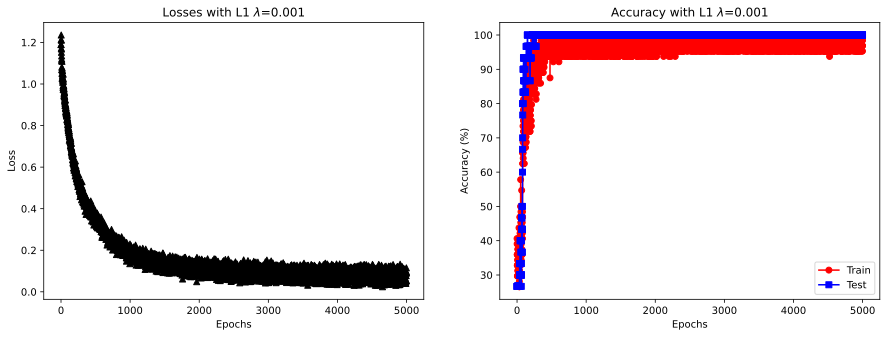

In [9]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, "k^-")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Losses with L1 $\\lambda$=" + str(L1Lambda))

ax[1].plot(trainAcc, "ro-")
ax[1].plot(testAcc, "bs-")
ax[1].set_title("Accuracy with L1 $\\lambda$=" + str(L1Lambda))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend(["Train", "Test"])

plt.show()